# **Pembuatan Chatbot Konsultasi Kesehatan Menggunakan SimpleRNN**

## **Kelompok 66 — Mata Kuliah Deep Learning**  
**Universitas Pendidikan Indonesia**  
**Semester 5 — Tahun 2025**

### **Anggota**
- **Muhamad Khafabillah Sopian** (2307824)  
- **Abyan Laksono** (2304127)

---

## **Deskripsi Proyek**

Proyek ini bertujuan untuk membangun model **Chatbot Konsultasi Kesehatan** berbasis **Recurrent Neural Network (RNN)** dengan arsitektur **SimpleRNN** sebagai model *baseline*.  

Fokus penelitian ini adalah mengukur kemampuan SimpleRNN dalam memahami dan menghasilkan respons yang relevan terhadap pertanyaan-pertanyaan kesehatan dalam Bahasa Indonesia.  
Hasil dari model ini nantinya akan dibandingkan dengan model **LSTM** untuk menilai perbedaan kinerja antar arsitektur RNN.

## **Import Library**

### **Penjelasan Singkat**
Pada tahap ini, semua pustaka (*library*) yang dibutuhkan untuk proyek ini akan diimpor.  
Setiap pustaka memiliki fungsi yang berbeda, antara lain:

* **Pandas & NumPy:** Untuk memuat, memanipulasi, dan mengolah data.  
* **TensorFlow / Keras:** Untuk membangun model **SimpleRNN** (Encoder–Decoder).  
* **OS** digunakan untuk mengakses dan mengelola file atau folder di sistem operasi dari dalam kode Python.
* **Tokenizer & pad_sequences:** Untuk melakukan pra-pemrosesan teks seperti tokenisasi dan padding.  
* **NLTK:** Untuk menghitung metrik evaluasi standar NLP, yaitu **BLEU Score**.  
* **Google.colab (drive):** Untuk mengakses dataset yang tersimpan di Google Drive (jika dijalankan di Google Colab).  
* **Matplotlib:** Untuk menampilkan visualisasi hasil pelatihan model.  
* **Sklearn:** Untuk melakukan pembagian data (*train–test split*) serta evaluasi tambahan.

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## **Load Data**

### **Penjelasan Singkat**
Tahap ini bertujuan untuk **memuat dataset chatbot** dari direktori Google Drive ke dalam lingkungan kerja (misalnya Google Colab).  
Dataset yang digunakan terdiri dari dua bagian:
- `doctorQnA_train.csv` → digunakan untuk proses pelatihan model.  
- `doctorQnA_test.csv` → digunakan untuk pengujian performa model.  

Pada tahap ini, kita hanya membaca data dan menampilkan informasi dasarnya seperti jumlah baris, kolom, serta beberapa contoh isi data.  
Proses pembersihan atau penyaringan data akan dilakukan nanti pada tahap *Exploratory Data Analysis (EDA)* dan *Praproses*.


In [48]:
BASE_DIR = "/content/drive/MyDrive/Deep Learning"
TRAIN_FILE = "doctorQnA_train.csv"
TEST_FILE  = "doctorQnA_test.csv"

train_path = os.path.join(BASE_DIR, TRAIN_FILE)
test_path  = os.path.join(BASE_DIR, TEST_FILE)

df_train = pd.read_csv(train_path, encoding="utf-8")
df_test  = pd.read_csv(test_path, encoding="utf-8")

print("=== INFORMASI DATA TRAIN ===")
print(df_train.info())
print("\n=== INFORMASI DATA TEST ===")
print(df_test.info())

print("\nJumlah baris dan kolom (Train):", df_train.shape)
print("Jumlah baris dan kolom (Test) :", df_test.shape)

print("\nContoh data train:")
print(df_train.head())

print("\nContoh data test:")
print(df_test.head())


=== INFORMASI DATA TRAIN ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5694 entries, 0 to 5693
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5694 non-null   object
 1   answer    5694 non-null   object
dtypes: object(2)
memory usage: 89.1+ KB
None

=== INFORMASI DATA TEST ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  633 non-null    object
 1   answer    633 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB
None

Jumlah baris dan kolom (Train): (5694, 2)
Jumlah baris dan kolom (Test) : (633, 2)

Contoh data train:
                                            question  \
0  Assalamaualaikum dok, saya mau konsul mengenai...   
1  Selamat sore dok, kemarin saya terpeleset, ter...   
2  Selamat sore dok, minggu kemarin anak saya sun...   
3  Selam

### **Exploratory Data Analysis (EDA)**

Pada bagian ini dilakukan analisis awal terhadap dataset untuk memahami karakteristik data sebelum dilakukan praprosesan.  
Analisis meliputi:
1. Jumlah data pada train dan test set.  
2. Pemeriksaan nilai kosong (missing values).  
3. Pengamatan panjang teks pada kolom **question** dan **answer** untuk melihat sebaran panjang kalimat.

In [49]:
# Jumlah data
print("Jumlah data train :", len(df_train))
print("Jumlah data test  :", len(df_test))

# Cek nilai kosong
print("\nJumlah nilai kosong per kolom (train):")
print(df_train.isnull().sum())

print("\nJumlah nilai kosong per kolom (test):")
print(df_test.isnull().sum())

# Panjang teks pada kolom question dan answer
df_train["q_length"] = df_train["question"].apply(len)
df_train["a_length"] = df_train["answer"].apply(len)
df_test["q_length"] = df_test["question"].apply(len)
df_test["a_length"] = df_test["answer"].apply(len)

print("\nRata-rata panjang karakter dalam teks (train):")
print("Pertanyaan :", df_train["q_length"].mean())
print("Jawaban    :", df_train["a_length"].mean())

print("\nRata-rata panjang karakter dalam teks (test):")
print("Pertanyaan :", df_test["q_length"].mean())
print("Jawaban    :", df_test["a_length"].mean())

Jumlah data train : 5694
Jumlah data test  : 633

Jumlah nilai kosong per kolom (train):
question    0
answer      0
dtype: int64

Jumlah nilai kosong per kolom (test):
question    0
answer      0
dtype: int64

Rata-rata panjang karakter dalam teks (train):
Pertanyaan : 285.11433087460483
Jawaban    : 439.3602037232174

Rata-rata panjang karakter dalam teks (test):
Pertanyaan : 284.01895734597156
Jawaban    : 445.97630331753555


### **Visualisasi Distribusi Panjang Teks**

Visualisasi ini digunakan untuk melihat persebaran panjang teks pada kolom **question** dan **answer**.  
Grafik histogram membantu memahami apakah sebagian besar pertanyaan dan jawaban memiliki panjang yang mirip, atau terdapat variasi yang signifikan.

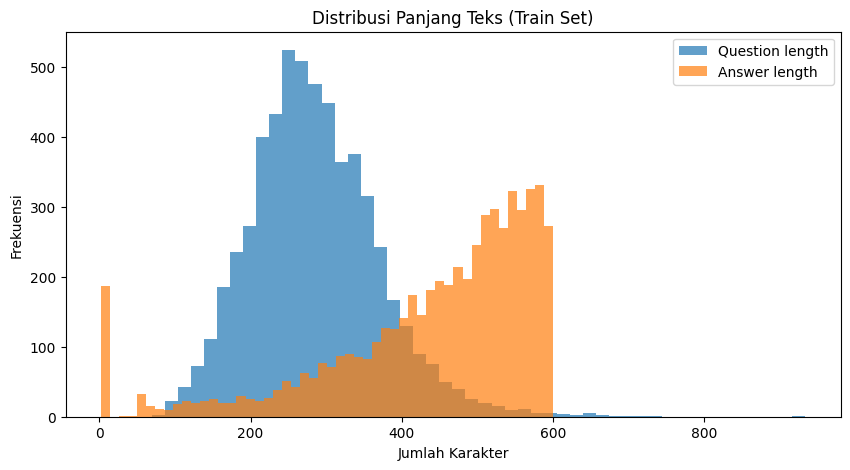

In [50]:
plt.figure(figsize=(10,5))
plt.hist(df_train["q_length"], bins=50, alpha=0.7, label="Question length")
plt.hist(df_train["a_length"], bins=50, alpha=0.7, label="Answer length")
plt.title("Distribusi Panjang Teks (Train Set)")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

**Penjelasan Hasil Visualisasi**

Grafik di atas menampilkan **distribusi panjang teks** untuk kolom *question* (pertanyaan) dan *answer* (jawaban) pada dataset pelatihan.  
Dari grafik tersebut dapat diamati bahwa sebagian besar teks memiliki panjang dalam rentang **sekitar 100 hingga 600 karakter**, dengan puncak frekuensi pada kisaran **250–400 karakter**.  

Hal ini menunjukkan bahwa pertanyaan dan jawaban dalam dataset memiliki **panjang yang relatif seragam** serta tidak terdapat perbedaan yang signifikan antara distribusi keduanya.  
Informasi ini penting untuk menentukan parameter **`maxlen`** saat proses tokenisasi, agar semua urutan teks memiliki panjang yang sesuai tanpa kehilangan konteks penting.

### **Praproses Data**

Tahap praproses bertujuan untuk **membersihkan teks** agar siap digunakan dalam pelatihan model.  
Beberapa langkah yang dilakukan meliputi:
1. Mengubah seluruh teks menjadi huruf kecil (*lowercasing*).  
2. Menghapus karakter yang tidak diperlukan seperti angka, tanda baca, dan simbol.  
3. Menghapus spasi berlebih.  
4. Membersihkan karakter yang tidak terbaca akibat encoding (misalnya karakter aneh pada dataset).  

Langkah ini penting agar data yang dimasukkan ke model lebih konsisten dan mudah dipelajari oleh Neural Network.

In [51]:
# Membersihkan teks pada kolom question dan answer

def clean_text(text):
    text = str(text).lower()                        # ubah ke huruf kecil
    text = re.sub(r"http\\S+|www\\S+", " ", text)   # hapus URL
    text = re.sub(r"[^a-zA-Z0-9\\s]", " ", text)    # hapus tanda baca & simbol
    text = re.sub(r"\\s+", " ", text).strip()       # hapus spasi berlebih
    return text

df_train["clean_question"] = df_train["question"].apply(clean_text)
df_train["clean_answer"]   = df_train["answer"].apply(clean_text)
df_test["clean_question"]  = df_test["question"].apply(clean_text)
df_test["clean_answer"]    = df_test["answer"].apply(clean_text)

# Cek hasil pembersihan
print("Sebelum dibersihkan:")
print(df_train.loc[0, "question"])
print("\nSetelah dibersihkan:")
print(df_train.loc[0, "clean_question"])

Sebelum dibersihkan:
Assalamaualaikum dok, saya mau konsul mengenai feses bayi. Bayi saya baru berusia 3 bulan, semalam pup warna fesesnya kuning pucat. Padahal sore harinya saat pup fesesnya berwarna normal, bayi saya minum asui dan sufor dok. Kondisinya bayi saya tidak sedang demam, tidak rewel dan masih aktif. Apakah berbahaya dok?

Setelah dibersihkan:
assalamaualaikum dok  saya mau konsul mengenai feses bayi  bayi saya baru berusia 3 bulan  semalam pup warna fesesnya kuning pucat  padahal sore harinya saat pup fesesnya berwarna normal  bayi saya minum asui dan sufor dok  kondisinya bayi saya tidak sedang demam  tidak rewel dan masih aktif  apakah berbahaya dok


### Tokenisasi dan Padding

Langkah ini menyiapkan data teks menjadi bentuk numerik agar dapat diproses oleh model RNN.  
Proses ini mencakup:
- Membuat tokenizer untuk pertanyaan (encoder) dan jawaban (decoder).  
- Menambahkan token khusus pada jawaban (`sostok` sebagai penanda awal dan `eostok` sebagai penanda akhir).  
- Mengonversi setiap teks menjadi deretan angka (sequence).  
- Melakukan padding supaya semua urutan memiliki panjang seragam.

In [52]:
Q_COL = "clean_question" if "clean_question" in df_train.columns else "question"
A_COL = "clean_answer" if "clean_answer" in df_train.columns else "answer"

train_questions = df_train[Q_COL].astype(str).tolist()
train_answers = df_train[A_COL].astype(str).tolist()

test_questions = df_test[Q_COL].astype(str).tolist()
test_answers = df_test[A_COL].astype(str).tolist()

train_answers_inp = [f"sostok {t}" for t in train_answers]
train_answers_out = [f"{t} eostok" for t in train_answers]
test_answers_inp = [f"sostok {t}" for t in test_answers]
test_answers_out = [f"{t} eostok" for t in test_answers]

VOCAB_Q = 30000
VOCAB_A = 30000

tok_q = Tokenizer(num_words=VOCAB_Q, oov_token="<OOV>")
tok_a = Tokenizer(num_words=VOCAB_A, oov_token="<OOV>")

tok_q.fit_on_texts(train_questions)
tok_a.fit_on_texts(train_answers_inp + train_answers_out)

def pct95_len(texts):
    lengths = np.array([len(t.split()) for t in texts])
    return int(np.percentile(lengths, 95))

MAX_LEN_Q = max(8, pct95_len(train_questions))
MAX_LEN_A = max(8, pct95_len(train_answers_out))

enc_train = tok_q.texts_to_sequences(train_questions)
dec_in_train = tok_a.texts_to_sequences(train_answers_inp)
dec_out_train = tok_a.texts_to_sequences(train_answers_out)

enc_test = tok_q.texts_to_sequences(test_questions)
dec_in_test = tok_a.texts_to_sequences(test_answers_inp)
dec_out_test = tok_a.texts_to_sequences(test_answers_out)

enc_train_pad = pad_sequences(enc_train, maxlen=MAX_LEN_Q, padding="post", truncating="post")
dec_in_train_pad = pad_sequences(dec_in_train, maxlen=MAX_LEN_A, padding="post", truncating="post")
dec_out_train_pad = pad_sequences(dec_out_train, maxlen=MAX_LEN_A, padding="post", truncating="post")

enc_test_pad = pad_sequences(enc_test, maxlen=MAX_LEN_Q, padding="post", truncating="post")
dec_in_test_pad = pad_sequences(dec_in_test, maxlen=MAX_LEN_A, padding="post", truncating="post")
dec_out_test_pad = pad_sequences(dec_out_test, maxlen=MAX_LEN_A, padding="post", truncating="post")

print("Jumlah kata unik encoder :", len(tok_q.word_index))
print("Jumlah kata unik decoder :", len(tok_a.word_index))
print("MAX_LEN_Q:", MAX_LEN_Q, "| MAX_LEN_A:", MAX_LEN_A)
print("enc_train_pad:", enc_train_pad.shape, "| dec_in_train_pad:", dec_in_train_pad.shape)

Jumlah kata unik encoder : 9393
Jumlah kata unik decoder : 11822
MAX_LEN_Q: 70 | MAX_LEN_A: 84
enc_train_pad: (5694, 70) | dec_in_train_pad: (5694, 84)


### **Pembangunan Model (SimpleRNN Encoder–Decoder)**

Model ini menggunakan arsitektur **sequence-to-sequence (seq2seq)** berbasis **SimpleRNN**.  
Encoder akan membaca dan memahami konteks pertanyaan, sedangkan decoder akan menghasilkan jawaban berdasarkan representasi konteks tersebut.  

Komponen utama:
- **Embedding Layer:** mengubah indeks kata menjadi representasi vektor.  
- **Encoder RNN:** menghasilkan *context vector* dari input pertanyaan.  
- **Decoder RNN:** menghasilkan token jawaban secara bertahap berdasarkan context vector.  
- **Dense Layer:** memprediksi token berikutnya di setiap langkah waktu dengan aktivasi *softmax*.

In [53]:
VOCAB_SIZE_Q = min(30000, len(tok_q.word_index) + 1)
VOCAB_SIZE_A = min(30000, len(tok_a.word_index) + 1)

EMB_DIM = 256
RNN_UNITS = 256

# Encoder
enc_inputs = Input(shape=(MAX_LEN_Q,))
enc_emb = Embedding(input_dim=VOCAB_SIZE_Q, output_dim=EMB_DIM, mask_zero=True)(enc_inputs)
enc_out, enc_state = SimpleRNN(RNN_UNITS, return_state=True)(enc_emb)

# Decoder
dec_inputs = Input(shape=(MAX_LEN_A,))
dec_emb = Embedding(input_dim=VOCAB_SIZE_A, output_dim=EMB_DIM, mask_zero=True)(dec_inputs)
dec_out = SimpleRNN(RNN_UNITS, return_sequences=True)(dec_emb, initial_state=enc_state)
dec_dense = Dense(VOCAB_SIZE_A, activation="softmax")(dec_out)

model = Model([enc_inputs, dec_inputs], dec_dense)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 84)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 70, 256)   │  2,404,864 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 70)        │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 84, 256)   │  3,026,688 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_6        │ [(None, 256),     │    131,328 │ embedding_6[0][0… │
│ (SimpleRNN)         │ (None, 256)]      │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_7        │ (None, 84, 256)   │    131,328 │ embedding_7[0][0… │
│ (SimpleRNN)         │                   │            │ simple_rnn_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 84, 11823) │  3,038,511 │ simple_rnn_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,732,719 (33.31 MB)

 Trainable params: 8,732,719 (33.31 MB)

 Non-trainable params: 0 (0.00 B)

### Pembagian Data

Data dibagi menjadi dua bagian: **train** untuk melatih model dan **validation** untuk memantau performa selama pelatihan agar tidak overfitting. Pasangan input–target dijaga konsisten: encoder input (`enc_train_pad`), decoder input (`dec_in_train_pad`), dan decoder target (`dec_out_train_pad`).


In [54]:
from sklearn.model_selection import train_test_split

X_enc_tr, X_enc_val, X_dec_in_tr, X_dec_in_val, y_tr, y_val = train_test_split(
    enc_train_pad, dec_in_train_pad, dec_out_train_pad,
    test_size=0.1, random_state=42
)

print("Train shapes  :", X_enc_tr.shape, X_dec_in_tr.shape, y_tr.shape)
print("Valid  shapes :", X_enc_val.shape, X_dec_in_val.shape, y_val.shape)

Train shapes  : (5124, 70) (5124, 84) (5124, 84)
Valid  shapes : (570, 70) (570, 84) (570, 84)


### Kontrol (hasil konsisten antar *Run All*)

Agar hasil pelatihan tidak berubah-ubah saat *Run All*

In [55]:
SEED = 42

# Kunci hash & deterministik TF (sebelum TF memuat ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"             # aktifkan ops deterministik (jika didukung)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"    # untuk deterministik di GPU NVIDIA (jika berlaku)

# Seed di tiga level
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# (Opsional, TF 2.13+): aktifkan deterministik via API
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception as e:
    pass

print("Seed & determinism set. SEED =", SEED)

Seed & determinism set. SEED = 42


### **Pelatihan Model**

Model SimpleRNN yang sudah dibangun akan dilatih menggunakan **data train** dan dievaluasi pada **data validasi**.  
Optimasi dilakukan menggunakan algoritma **Adam**, dengan fungsi loss `sparse_categorical_crossentropy`, karena target output berupa indeks kata.  
Callback **EarlyStopping** digunakan untuk menghentikan pelatihan otomatis jika performa validasi tidak membaik selama beberapa epoch, sementara **ModelCheckpoint** menyimpan bobot model terbaik.

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Konfigurasi callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("model_simplernn_best.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Kompilasi model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Proses pelatihan
history = model.fit(
    [X_enc_tr, X_dec_in_tr],
    y_tr,
    validation_data=([X_enc_val, X_dec_in_val], y_val),
    epochs=20,
    batch_size=64,
    shuffle=False,    # agar hasil training konsisten
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0163 - loss: 7.6901
Epoch 1: val_loss improved from inf to 6.80371, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 481s 6s/step - accuracy: 0.0164 - loss: 7.6830 - val_accuracy: 0.0310 - val_loss: 6.8037
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0317 - loss: 6.7102
Epoch 2: val_loss improved from 6.80371 to 6.60534, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.0317 - loss: 6.7097 - val_accuracy: 0.0475 - val_loss: 6.6053
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0485 - loss: 6.4509
Epoch 3: val_loss improved from 6.60534 to 6.27920, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 475s 6s/step - accuracy: 0.0485 - loss: 6.4500 - val_accuracy: 0.0626 - val_loss: 6.2792
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0702 - loss: 6.0941
Epoch 4: val_loss improved from 6.27920 to 5.95216, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 472s 6s/step - accuracy: 0.0703 - loss: 6.0931 - val_accuracy: 0.0884 - val_loss: 5.9522
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0994 - loss: 5.7257
Epoch 5: val_loss improved from 5.95216 to 5.61748, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 457s 6s/step - accuracy: 0.0995 - loss: 5.7247 - val_accuracy: 0.1144 - val_loss: 5.6175
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1239 - loss: 5.3588
Epoch 6: val_loss improved from 5.61748 to 5.35265, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.1239 - loss: 5.3580 - val_accuracy: 0.1304 - val_loss: 5.3527
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1414 - loss: 5.0530
Epoch 7: val_loss improved from 5.35265 to 5.15896, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.1415 - loss: 5.0523 - val_accuracy: 0.1431 - val_loss: 5.1590
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1566 - loss: 4.8025
Epoch 8: val_loss improved from 5.15896 to 5.00744, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 478s 6s/step - accuracy: 0.1567 - loss: 4.8020 - val_accuracy: 0.1531 - val_loss: 5.0074
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1686 - loss: 4.5967
Epoch 9: val_loss improved from 5.00744 to 4.90421, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 487s 6s/step - accuracy: 0.1686 - loss: 4.5964 - val_accuracy: 0.1610 - val_loss: 4.9042
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1781 - loss: 4.4276
Epoch 10: val_loss improved from 4.90421 to 4.83278, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step - accuracy: 0.1781 - loss: 4.4273 - val_accuracy: 0.1652 - val_loss: 4.8328
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1871 - loss: 4.2783
Epoch 11: val_loss improved from 4.83278 to 4.74627, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 520s 6s/step - accuracy: 0.1872 - loss: 4.2780 - val_accuracy: 0.1721 - val_loss: 4.7463
Epoch 12/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1957 - loss: 4.1389
Epoch 12: val_loss improved from 4.74627 to 4.69799, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 474s 6s/step - accuracy: 0.1957 - loss: 4.1386 - val_accuracy: 0.1765 - val_loss: 4.6980
Epoch 13/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2032 - loss: 4.0174
Epoch 13: val_loss improved from 4.69799 to 4.63662, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - accuracy: 0.2032 - loss: 4.0171 - val_accuracy: 0.1803 - val_loss: 4.6366
Epoch 14/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2107 - loss: 3.8989
Epoch 14: val_loss improved from 4.63662 to 4.59539, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 463s 6s/step - accuracy: 0.2107 - loss: 3.8986 - val_accuracy: 0.1835 - val_loss: 4.5954
Epoch 15/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2181 - loss: 3.7878
Epoch 15: val_loss improved from 4.59539 to 4.57333, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 523s 6s/step - accuracy: 0.2181 - loss: 3.7876 - val_accuracy: 0.1854 - val_loss: 4.5733
Epoch 16/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2256 - loss: 3.6891
Epoch 16: val_loss improved from 4.57333 to 4.56066, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 472s 6s/step - accuracy: 0.2256 - loss: 3.6889 - val_accuracy: 0.1884 - val_loss: 4.5607
Epoch 17/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2328 - loss: 3.6041
Epoch 17: val_loss improved from 4.56066 to 4.52424, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 505s 6s/step - accuracy: 0.2329 - loss: 3.6039 - val_accuracy: 0.1910 - val_loss: 4.5242
Epoch 18/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2402 - loss: 3.5128
Epoch 18: val_loss did not improve from 4.52424
81/81 ━━━━━━━━━━━━━━━━━━━━ 479s 6s/step - accuracy: 0.2402 - loss: 3.5126 - val_accuracy: 0.1924 - val_loss: 4.5255
Epoch 19/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2467 - loss: 3.4374
Epoch 19: val_loss improved from 4.52424 to 4.50193, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 459s 6s/step - accuracy: 0.2467 - loss: 3.4373 - val_accuracy: 0.1934 - val_loss: 4.5019
Epoch 20/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2536 - loss: 3.3646
Epoch 20: val_loss improved from 4.50193 to 4.49146, saving model to model_simplernn_best.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 469s 6s/step - accuracy: 0.2537 - loss: 3.3644 - val_accuracy: 0.1959 - val_loss: 4.4915
Restoring model weights from the end of the best epoch: 20.


### **Visualisasi Performa Model**

Grafik berikut menampilkan perkembangan *loss* dan *akurasi* selama proses pelatihan model SimpleRNN.  
Tujuannya untuk melihat seberapa baik model belajar dari data latih dan seberapa baik kemampuannya dalam melakukan generalisasi terhadap data validasi.


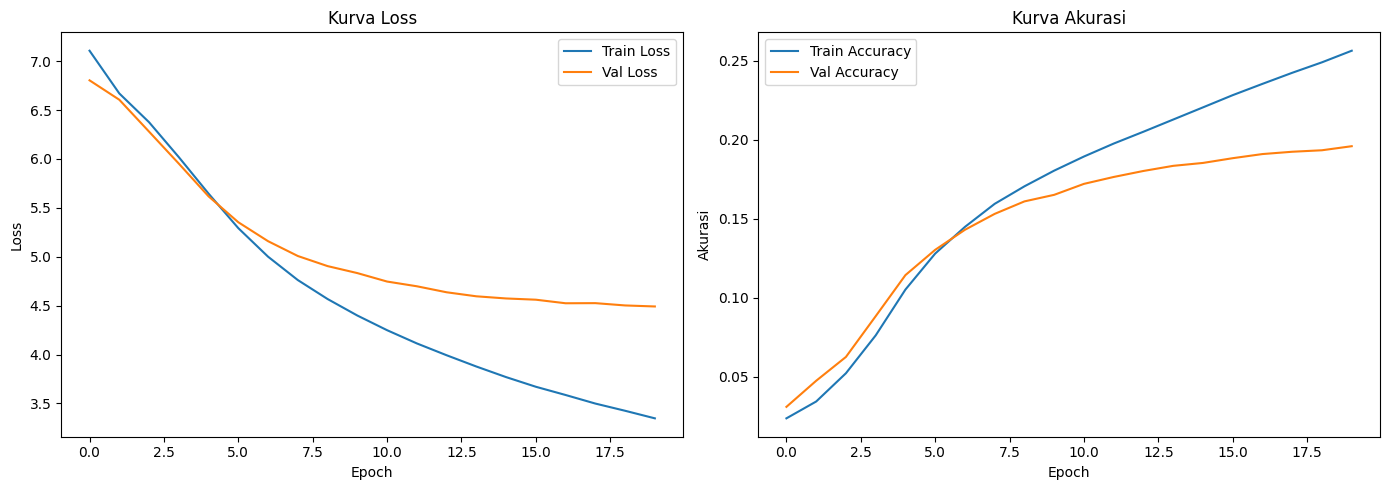

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Grafik Loss
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].plot(history.history["val_loss"], label="Val Loss")
ax[0].set_title("Kurva Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Grafik Akurasi
ax[1].plot(history.history["accuracy"], label="Train Accuracy")
ax[1].plot(history.history["val_accuracy"], label="Val Accuracy")
ax[1].set_title("Kurva Akurasi")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Akurasi")
ax[1].legend()

plt.tight_layout()
plt.show()


**Penjelasan Grafik**

- **Kurva Loss** menunjukkan seberapa besar kesalahan model selama pelatihan.  
  Nilai *loss* yang menurun pada train dan val menandakan bahwa model berhasil belajar pola data secara stabil.
  
- **Kurva Akurasi** memperlihatkan tingkat ketepatan model dalam memprediksi token secara benar.  
  Jika *val_accuracy* ikut meningkat bersama *train_accuracy*, berarti model tidak hanya hafal data latih, tapi juga mampu memahami pola pada data baru (tidak overfitting).

Secara keseluruhan, kedua grafik ini membantu menilai apakah proses pelatihan berjalan dengan baik dan konvergen.

### **Evaluasi dan Pengujian Model**

Pada tahap ini, model **SimpleRNN** diuji menggunakan data *testing* untuk melihat kemampuannya dalam menghasilkan jawaban otomatis terhadap pertanyaan kesehatan.  
Fungsi `predict_answer()` digunakan untuk menguji model dengan input pertanyaan dan menghasilkan output teks jawaban.  
Hasil prediksi dibandingkan dengan jawaban referensi untuk menilai tingkat relevansi dan koherensi model.

In [68]:
idx2word_a = {v: k for k, v in tok_a.word_index.items()}
idx2word_a[0] = "<PAD>"
sostok_id = tok_a.word_index["sostok"]
eostok_id = tok_a.word_index["eostok"]

def predict_answer(question_text, max_len=MAX_LEN_A):
    # Ubah pertanyaan menjadi token & padding
    q_seq = tok_q.texts_to_sequences([question_text])
    q_pad = pad_sequences(q_seq, maxlen=MAX_LEN_Q, padding="post", truncating="post")

    # Siapkan input decoder: mulai dari token awal
    dec_seq = np.zeros((1, max_len), dtype="int32")
    dec_seq[0, 0] = sostok_id

    # Greedy decoding: prediksi token demi token
    for t in range(1, max_len):
        # Prediksi seluruh urutan saat ini, ambil logits posisi terakhir yang terisi
        logits = model.predict([q_pad, dec_seq], verbose=0)       # (1, max_len, vocab)
        next_id = int(np.argmax(logits[0, t-1, :]))
        if next_id in (0, eostok_id):
            break
        dec_seq[0, t] = next_id

    # Konversi token ke kata (buang token khusus)
    tokens = [int(x) for x in dec_seq[0] if x not in (0, sostok_id, eostok_id)]
    return " ".join(idx2word_a.get(tok, "<UNK>") for tok in tokens).strip()

# Uji cepat pada 5 sampel test
for i in range(5):
    q = df_test["question"][i]
    ref = df_test["answer"][i]
    pred = predict_answer(q)
    print(f"\n[Contoh {i+1}]")
    print("Pertanyaan :", q[:300], "..." if len(q) > 300 else "")
    print("Model      :", pred if pred else "(kosong)")
    print("Referensi  :", ref[:300], "..." if len(ref) > 300 else "")


[Contoh 1]
Pertanyaan : Halo dok, saya remaja 15 tahun. Saya sedang haid hari ke 3. Biasanya siklus haid saya selama 7 hari. Lusa saya ada pengambilan nilai olahraga renang dok. Semua siswa diwajibkan untuk ikut dok, tapi kan saya sedang haid dok. Apakah ada cara untuk menghentikan darah haid selama saya berenang dok? moho ...
Model      : alo terima kasih atas pertanyaannya untuk alodokter kondisi kulit yang terasa gatal dan gatal di kulit yang terasa gatal dan perih di sekitar mata yang terasa nyeri dan terasa nyeri di sekitar dada dan sebagainya
Referensi  : Menstruasi sewajarnya akan berlangsung selama 2 hingga 8 hari. Namun, ada saja wanita yang durasi menstruasinya lebih singkat, atau justru lebih lama dari itu. Hal ini banyak dipengaruhi oleh kondisi hormonal, genetik, aktifitas, gaya hidup yang dijalani, kondisi psikis, dan status kesehatan secara  ...

[Contoh 2]
Pertanyaan : Putra saya usia 15 th, testis kirinya sakit dok, gada bengkak atau apa, itu kira-kira kenapa ya dokte

### **Kesimpulan**

Proyek ini berhasil membangun Chatbot Konsultasi Kesehatan berbasis SimpleRNN dengan arsitektur sequence-to-sequence menggunakan dataset Dokter QnA berbahasa Indonesia yang terdiri dari 5.694 data latih dan 633 data uji. Proses pengembangan dilakukan melalui beberapa tahapan, yaitu pemuatan data, eksplorasi, pembersihan teks, tokenisasi, padding, pembangunan model, serta pelatihan selama 20 epoch.  

Selama proses pelatihan, nilai loss mengalami penurunan signifikan dari 7.68 pada epoch pertama menjadi 3.36 pada epoch ke-20, sementara akurasi meningkat dari 0.016 menjadi sekitar 0.25. Nilai validasi juga menunjukkan tren serupa dengan penurunan loss dari 6.80 menjadi 4.49 dan peningkatan akurasi hingga 0.19. Hasil ini menandakan bahwa model berhasil mempelajari pola pertanyaan dan jawaban dari data pelatihan.  

Namun, hasil pengujian memperlihatkan bahwa respons yang dihasilkan model masih bersifat umum dan repetitif. Pola kalimat seperti “Alo terima kasih atas pertanyaannya...” sering muncul karena keterbatasan SimpleRNN dalam mengingat konteks panjang, distribusi data yang tidak seimbang, serta metode greedy decoding yang cenderung memilih token dengan probabilitas tertinggi secara berulang.  

Secara keseluruhan, model SimpleRNN ini telah berfungsi sesuai tujuan sebagai baseline chatbot untuk simulasi konsultasi kesehatan.